In [1]:
pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


d1_path = 'mendley_data.xlsx'
d2_path = 'kaggle_data.csv'


d1 = pd.read_excel(d1_path, sheet_name='Data', engine='openpyxl')
d2 = pd.read_csv(d2_path)


breed_mapping = {
    'BEN': 'Bengal',
    'SBI': 'Birman',
    'BRI': 'British Shorthair',
    'CHA': 'Chartreux',
    'EUR': 'European',
    'MCO': 'Maine coon',
    'PER': 'Persian',
    'RAG': 'Ragdoll',
    'SPH': 'Savannah',
    'ORI': 'Sphynx',
    'TUV': 'Siamese',
    'Autre': 'Other'
}
age_mapping = {
    'Moinsde1': 0.5,
    '1a2': 1.5,
    '2a10': 6,
    'Plusde10': 11
}

number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'Plusde5': 5
}

sex_mapping = {
    'M': 'M',
    'F': 'F'
}

housing_mapping = {
    'ASB': 'ASB',
    'AAB': 'AAB',
    'ML': 'ML',
    'MI': 'MI'
}

zone_mapping = {
    'U': 'U',
    'PU': 'PU',
    'R': 'R'
}

outdoor_time_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

interaction_time_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4
}

abundance_mapping = {
    '1': 1, '2': 2, '3': 3, 'NSP': 0
}

bird_capture_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

mammal_capture_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

default_mapping_values = {
    'Race': 'Other',
    'Number': 1,
    'Age': 1,
    'Sex': 'F',
    'Accommodation': 'ASB',
    'Area': 'U',
    'Ext': 1,
    'Obs': 1,
    'Abundance': 1,
    'PredBird': 1,
    'PredMamm': 1
}

mapping_dict = {
    'Race': breed_mapping,
    'Number': number_mapping,
    'Age': age_mapping,
    'Sex': sex_mapping,
    'Accommodation': housing_mapping,
    'Area': zone_mapping,
    'Ext': outdoor_time_mapping,
    'Obs': interaction_time_mapping,
    'Abundance': abundance_mapping,
    'PredBird': bird_capture_mapping,
    'PredMamm': mammal_capture_mapping
}



translator = GoogleTranslator(source='fr', target='en')
d1.columns = [translator.translate(col) for col in d1.columns]


optional_columns = ["Row.names", "Time stamp", "More"]
d1 = d1.drop(columns=[col for col in optional_columns if col in d1.columns], errors='ignore')



for column, mapping in mapping_dict.items():
    if column in d1.columns:
        d1[column] = d1[column].apply(
            lambda x: mapping.get(x, default_mapping_values[column]) if pd.notnull(x) else np.nan
        )

d1_cleaned = d1.drop_duplicates()
d1_cleaned = d1_cleaned.rename(columns={'Race': 'Breed'})
d2.rename(columns={'name': 'Breed'}, inplace=True)
d1_breeds = d1_cleaned['Breed'].unique()
d2_breeds = d2['Breed'].unique()

d1_cleaned['Breed'] = d1_cleaned['Breed'].apply(lambda x: breed_mapping.get(x, 'Other'))
#d2['Breed'] = d2['Breed'].apply(lambda x: breed_mapping.get(x, 'Other'))


unmapped_breeds_d1 = [breed for breed in d1_breeds if breed not in breed_mapping.keys()]
unmapped_breeds_d2 = [breed for breed in d2_breeds if breed not in breed_mapping.keys()]

# Update breed_mapping with unmapped breeds explicitly
for unmapped in unmapped_breeds_d1 + unmapped_breeds_d2:
    breed_mapping[unmapped] = 'Other'


merged_df = pd.merge(d1_cleaned, d2, on='Breed', how='outer')



categorical_columns = merged_df.select_dtypes(include=['object']).columns
category_mappings = {}
for col in categorical_columns:

    categories = merged_df[col].dropna().unique()
    category_mapping = {category: code for code, category in enumerate(categories)}
    category_mappings[col] = category_mapping

    merged_df[col] = pd.Categorical(merged_df[col], categories=merged_df[col].dropna().unique(), ordered=False)
    merged_df[col] = merged_df[col].cat.codes.replace(-1, np.nan)

for col, mapping in category_mappings.items():
    if col in merged_df.columns:
        reverse_mapping = {v: k for k, v in mapping.items()}

breed_mapping_2 = category_mappings.get('Breed', {})
print(f"Breed mapping: {breed_mapping_2}")
breed_to_label = {breed: label for breed, label in breed_mapping_2.items()}
label_to_breed = {label: breed for breed, label in breed_mapping_2.items()}

print("Breed to Label Mapping:")
print(breed_to_label)

print("Label to Breed Mapping:")
print(label_to_breed)

missing_cols = merged_df.columns[merged_df.isna().any()].tolist()
complete_cols = [col for col in merged_df.columns if col not in missing_cols]


def train_model_for_missing_value(column_name):
    train_df = merged_df[merged_df[column_name].notnull()]
    X = train_df.loc[train_df.index, complete_cols]
    y = train_df[column_name]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

    model = RandomForestRegressor(n_estimators=100, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    return model, mse



def augment_dataset(df, column_name, model):
    nan_rows = df[df[column_name].isna()]

    X_nan = df.loc[nan_rows.index, complete_cols]

    if not X_nan.empty:
        predicted_values = model.predict(X_nan)
        df.loc[df[column_name].isna(), column_name] = predicted_values
        print(f"Filled missing values for column: {column_name}")


numeric_missing_cols = [col for col in missing_cols if col in merged_df.columns]
results = {}
augmented_df = merged_df.copy()

for col in numeric_missing_cols:

    model, mse = train_model_for_missing_value(col)
    results[col] = {"model": model, "mse": mse}

    augment_dataset(augmented_df, col, model)


numeric_columns = augmented_df.select_dtypes(include=['float64', 'int64']).columns
augmented_df[numeric_columns] = augmented_df[numeric_columns].round(0).astype(int)


augmented_df.to_csv('augmented_dataset.csv', index=False)
print("Augmented dataset saved as 'augmented_dataset.csv'.")


Breed mapping: {'Abyssinian': 0, 'Aegean': 1, 'American Bobtail': 2, 'American Shorthair': 3, 'American Wirehair': 4, 'Aphrodite Giant': 5, 'Arabian Mau': 6, 'Asian': 7, 'Australian Mist': 8, 'Bambino': 9, 'Bengal': 10, 'Bengal Cats': 11, 'Birman': 12, 'Bombay': 13, 'Brazilian Shorthair': 14, 'British Longhair': 15, 'British Shorthair': 16, 'Burmese': 17, 'Burmilla': 18, 'California Spangled': 19, 'Chantilly-Tiffany': 20, 'Chartreux': 21, 'Chausie': 22, 'Colorpoint Shorthair': 23, 'Cornish Rex': 24, 'Cyprus': 25, 'Devon Rex': 26, 'Donskoy': 27, 'European': 28, 'European Shorthair': 29, 'Foldex': 30, 'German Rex': 31, 'Highlander': 32, 'Japanese Bobtail': 33, 'Javanese': 34, 'Khao Manee': 35, 'Kurilian Bobtail': 36, 'Lykoi': 37, 'Maine Coon': 38, 'Maine coon': 39, 'Manx': 40, 'Mekong Bobtail': 41, 'Nebelung': 42, 'Oriental Bicolor': 43, 'Other': 44, 'Persian': 45, 'Peterbald': 46, 'Pixie-Bob': 47, 'Ragdoll': 48, 'Ragdoll Cats': 49, 'Russian Blue': 50, 'Savannah': 51, 'Scottish Fold': 52

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

augmented_data_path = 'augmented_dataset.csv'
augmented_df = pd.read_csv(augmented_data_path)


X = augmented_df.drop(columns=['Breed']).values
Y = augmented_df['Breed'].values


X = X / np.max(X, axis=0)


def convert_labels(labels):
    labels = np.array(labels).astype(int)
    classes = np.unique(labels).shape[0]
    matrix = np.zeros((labels.shape[0], classes))
    matrix[np.arange(labels.shape[0]), labels] = 1
    return matrix

Y = convert_labels(Y)



train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=50)


np.random.seed(50)
input_size = train_X.shape[1]
hidden_layer_1 = 150
hidden_layer_2 = 100
classes = train_Y.shape[1]
print(f"Number of unique breeds: {classes}")
dropout_rate = 0.2
reg_lambda = 0.0002

W1 = np.random.randn(input_size, hidden_layer_1) * np.sqrt(2 / input_size)
b1 = np.zeros((1, hidden_layer_1))
W2 = np.random.randn(hidden_layer_1, hidden_layer_2) * np.sqrt(2 / hidden_layer_1)
b2 = np.zeros((1, hidden_layer_2))
W3 = np.random.randn(hidden_layer_2, classes) * np.sqrt(2 / hidden_layer_2)
b3 = np.zeros((1, classes))


def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)


def cross_entropy_loss(y, y_pred):
    eps = 1e-8
    return -np.sum(y * np.log(y_pred + eps)) / y.shape[0]


def gradient_descent(X, y, W1, b1, W2, b2, W3, b3, learning_rate):

    z1 = relu(X @ W1 + b1)
    z1 = apply_dropout(z1, dropout_rate)

    z2 = relu(z1 @ W2 + b2)
    z2 = apply_dropout(z2, dropout_rate)

    y_pred = softmax(z2 @ W3 + b3)


    loss = cross_entropy_loss(y, y_pred)
    loss += reg_lambda * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2)) # sqrt?


    err_output = y_pred - y

    dW3 = z2.T @ err_output / X.shape[0] + reg_lambda * W3
    db3 = np.sum(err_output, axis=0, keepdims=True) / X.shape[0]

    err_hidden_2 = (err_output @ W3.T) * relu_derivative(z2)
    dW2 = z1.T @ err_hidden_2 / X.shape[0] + reg_lambda * W2
    db2 = np.sum(err_hidden_2, axis=0, keepdims=True) / X.shape[0]

    err_hidden_1 = (err_hidden_2 @ W2.T) * relu_derivative(z1)
    dW1 = X.T @ err_hidden_1 / X.shape[0] + reg_lambda * W1
    db1 = np.sum(err_hidden_1, axis=0, keepdims=True) / X.shape[0]

    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    return W1, b1, W2, b2, W3, b3, loss


def update_learning_rate(epoch, current_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement):
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= threshold:
        lr = max(lr * (decay_factor ** epoch), min_lr)
        epochs_since_improvement = 0

    return lr, best_loss, epochs_since_improvement


def apply_dropout(A, rate):
    mask = np.random.binomial(1, 1 - rate, size=A.shape)
    return A * mask / (1 - rate)


def accuracy(X, y, W1, b1, W2, b2, W3, b3):

    z1 = relu(X @ W1 + b1)
    z2 = relu(z1 @ W2 + b2)
    y_pred = softmax(z2 @ W3 + b3)

    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y, axis=1)
    return np.mean(predicted_classes == true_classes)


def train_with_scheduler(train_X, train_Y, test_X, test_Y, W1, b1, W2, b2, W3, b3, epochs, batch_size, initial_lr, threshold, decay_factor, min_lr):
    num_batches = np.ceil(train_X.shape[0] / batch_size).astype(int)
    lr = initial_lr
    best_loss = float('inf')
    epochs_since_improvement = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        shuffle_indices = np.random.permutation(train_X.shape[0])
        train_X_shuffled = train_X[shuffle_indices]
        train_Y_shuffled = train_Y[shuffle_indices]

        epoch_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, train_X.shape[0])
            X_batch = train_X_shuffled[start:end]
            y_batch = train_Y_shuffled[start:end]

            W1, b1, W2, b2, W3, b3, batch_loss = gradient_descent(X_batch, y_batch, W1, b1, W2, b2, W3, b3, learning_rate=lr)
            epoch_loss += batch_loss

        epoch_loss /= num_batches

        lr, best_loss, epochs_since_improvement = update_learning_rate(
            epoch, epoch_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement
        )

        train_losses.append(epoch_loss)
        test_loss = cross_entropy_loss(test_Y, softmax(relu(relu(test_X @ W1 + b1) @ W2 + b2) @ W3 + b3))
        test_losses.append(test_loss)

        train_acc = accuracy(train_X, train_Y, W1, b1, W2, b2, W3, b3)
        val_acc = accuracy(test_X, test_Y, W1, b1, W2, b2, W3, b3)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {test_loss:.4f}, Learning Rate: {lr:.6f}")
        print(f"Training Accuracy: {train_acc * 100:.2f}%, Validation Accuracy: {val_acc * 100:.2f}%\n")

    return W1, b1, W2, b2, W3, b3, train_losses, test_losses


W1, b1, W2, b2, W3, b3, train_losses, test_losses = train_with_scheduler(
    train_X, train_Y, test_X, test_Y,
    W1, b1, W2, b2, W3, b3,
    epochs=100, batch_size=100, initial_lr=0.2, threshold=3, decay_factor=0.2, min_lr=0.01
)


test_accuracy = accuracy(test_X, test_Y, W1, b1, W2, b2, W3, b3)
print(f"Testing Data Accuracy: {test_accuracy * 100:.2f}%")



Number of unique breeds: 68
Epoch 1/100, Loss: 2.5805, Validation Loss: 1.6158, Learning Rate: 0.200000
Training Accuracy: 61.50%, Validation Accuracy: 59.53%

Epoch 2/100, Loss: 1.5928, Validation Loss: 1.1486, Learning Rate: 0.200000
Training Accuracy: 69.33%, Validation Accuracy: 67.34%

Epoch 3/100, Loss: 1.2921, Validation Loss: 0.9634, Learning Rate: 0.200000
Training Accuracy: 78.60%, Validation Accuracy: 74.06%

Epoch 4/100, Loss: 1.0132, Validation Loss: 0.7861, Learning Rate: 0.200000
Training Accuracy: 84.78%, Validation Accuracy: 81.41%

Epoch 5/100, Loss: 0.8926, Validation Loss: 0.6830, Learning Rate: 0.200000
Training Accuracy: 88.18%, Validation Accuracy: 85.78%

Epoch 6/100, Loss: 0.8130, Validation Loss: 0.7197, Learning Rate: 0.200000
Training Accuracy: 88.93%, Validation Accuracy: 85.47%

Epoch 7/100, Loss: 0.8315, Validation Loss: 0.6903, Learning Rate: 0.200000
Training Accuracy: 88.65%, Validation Accuracy: 86.72%

Epoch 8/100, Loss: 0.6968, Validation Loss: 0.94

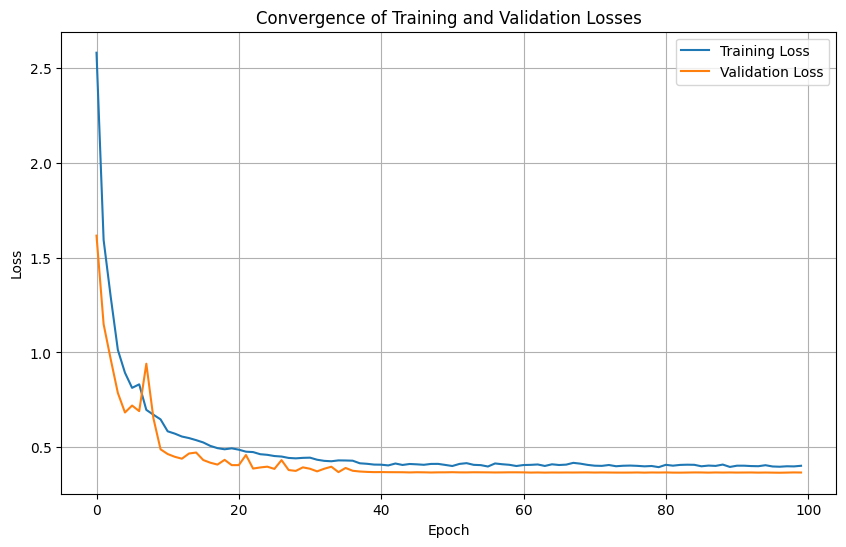

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergence of Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()


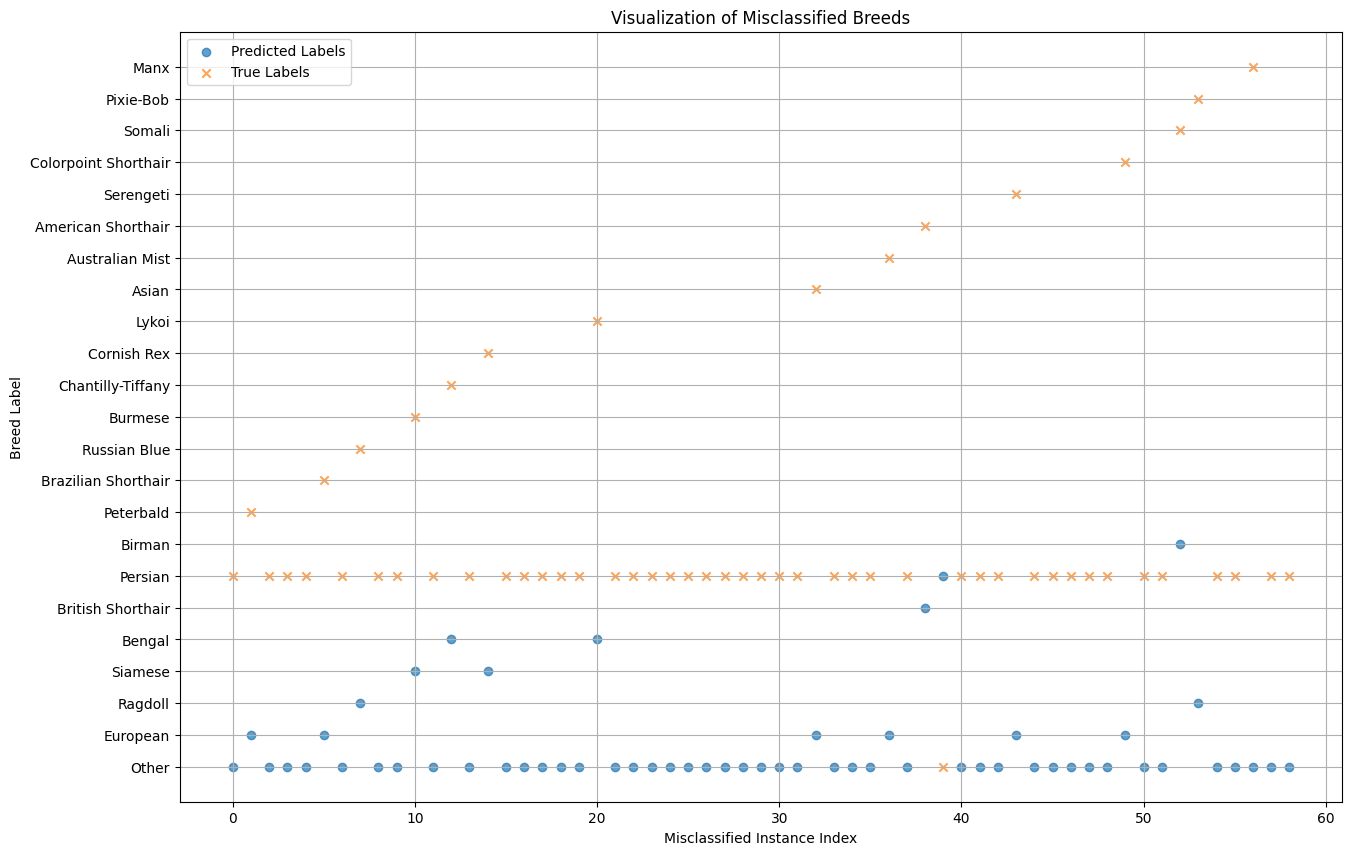

In [5]:
import numpy as np
import matplotlib.pyplot as plt

predictions = np.argmax(softmax(relu(relu(test_X @ W1 + b1) @ W2 + b2) @ W3 + b3), axis=1)
true_labels = np.argmax(test_Y, axis=1)
misclassified = predictions != true_labels

try:
    misclassified_indices = np.where(misclassified)[0]
    misclassified_data = test_X[misclassified_indices]
    misclassified_pred_labels = predictions[misclassified_indices]
    misclassified_true_labels = true_labels[misclassified_indices]

    misclassified_pred_breeds = [label_to_breed[label] for label in misclassified_pred_labels]
    misclassified_true_breeds = [label_to_breed[label] for label in misclassified_true_labels]


    plt.figure(figsize=(15, 10))
    plt.scatter(
        range(len(misclassified_indices)),
        misclassified_pred_breeds,
        label="Predicted Labels",
        alpha=0.7,
        marker='o'
    )
    plt.scatter(
        range(len(misclassified_indices)),
        misclassified_true_breeds,
        label="True Labels",
        alpha=0.7,
        marker='x'
    )
    plt.xlabel("Misclassified Instance Index")
    plt.ylabel("Breed Label")
    plt.title("Visualization of Misclassified Breeds")
    plt.legend()
    plt.grid()
    plt.show()

except NameError as e:
    print("Error: Missing variables or definitions in the context. Ensure earlier steps have been executed.")
    print(e)


## 2. Read a natural language description of a cat, extract relevant attributes and identify its breed.

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re


lemmatizer = WordNetLemmatizer()

raw_attribute_list = [

    "Sex", "Age", "Breed", "Number", "Accommodation", "Area",


    "Shy", "Calm", "Afraid", "Clever", "Vigilant", "Persevering",
    "Affectionate", "Friendly", "Lonely", "Brutal", "Dominant",
    "Aggressive", "Impulsive", "Predictable", "Distracted",


    "Ext", "Obs", "Abundance", "PredBird", "PredMamm",


    "length", "origin", "min_life_expectancy", "max_life_expectancy",
    "min_weight", "max_weight",


    "family_friendly", "shedding", "general_health", "playfulness",
    "children_friendly", "grooming", "intelligence", "other_pets_friendly"
]


attribute_list = [lemmatizer.lemmatize(attr.lower()) for attr in raw_attribute_list]


attribute_mapping = {
    "playfulness": ["playful", "energetic", "fun"],
    "intelligence": ["intelligent", "smart", "clever"],
    "friendly": ["sociable", "playful", "outgoing"],
    "affectionate": ["loving", "cuddly", "caring"],
    "calm": ["peaceful", "relaxed"],
    "aggressive": ["hostile", "violent", "not calm"],
}


opposite_attributes = {
    "calm": "aggressive",
    "aggressive": "calm",
    "aggressive": "friendly",
    "friendly": "aggressive",
    "affectionate": "lonely",
    "lonely": "affectionate"
}

intensity_mapping = {
    "very": 5,
    "extremely": 5,
    "highly": 5,
    "somewhat": 3,
    "moderately": 3,
    "slightly": 2,
    "barely": 1,
    "hardly": 1,
}

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemmatizer.lemmatize(lemma.name().replace("_", " ").lower()))
    return synonyms


def parse_text_to_attributes(text, attributes):
    extracted_attributes = {}
    updates_for_opposites = {}

    lemmatized_text = " ".join([lemmatizer.lemmatize(word.lower()) for word in re.findall(r'\w+', text)])
    print(f"Lemmatized Text: {lemmatized_text}")

    for attribute in attributes:
        synonyms = set(attribute_mapping.get(attribute, [])) | get_synonyms(attribute)

        for synonym in synonyms:
            pattern = rf"(?:(not|neither|nor|barely|hardly|somewhat|very|extremely|moderately|slightly)\s+)?\b{synonym}\b"
            matches = re.finditer(pattern, text, re.IGNORECASE)

            for match in matches:
                intensity = match.group(1)
                if intensity in {"not", "neither", "nor"}:
                    extracted_attributes[attribute] = 0
                elif intensity in intensity_mapping:
                    extracted_attributes[attribute] = intensity_mapping[intensity]
                else:
                    extracted_attributes[attribute] = 3


    for attr, value in extracted_attributes.items():
        if attr in opposite_attributes:
            opposite = opposite_attributes[attr]
            updates_for_opposites[opposite] = max(0, 5 - value)

    extracted_attributes.update(updates_for_opposites)

    return extracted_attributes


def prepare_input_vector(parsed_attributes, feature_columns):
    input_vector = np.zeros(len(feature_columns))
    for attribute, value in parsed_attributes.items():
        if attribute in feature_columns:
            index = feature_columns.index(attribute)
            input_vector[index] = value
    return input_vector


def normalize_input(input_vector, max_values):
    return input_vector / max_values


def predict_breed(input_vector, W1, b1, W2, b2, W3, b3):
    z1 = relu(input_vector @ W1 + b1)
    z2 = relu(z1 @ W2 + b2)
    y_pred = softmax(z2 @ W3 + b3)
    return np.argmax(y_pred), y_pred



def breed_mapping_prediction(description):

  parsed_attributes = parse_text_to_attributes(description, attribute_list)
  print(f"Parsed Attributes: {parsed_attributes}")
  feature_columns = augmented_df.drop(columns=["Breed"]).columns.tolist()
  max_values = np.max(X, axis=0)
  input_vector = prepare_input_vector(parsed_attributes, feature_columns)
  predicted_label, predicted_probs = predict_breed(input_vector, W1, b1, W2, b2, W3, b3)
  predicted_breed = label_to_breed.get(predicted_label, "Unknown")
  return predicted_breed
  #print(f"Predicted Breed: {predicted_breed}")
  #print(f"Prediction Probabilities: {predicted_probs}")






In [8]:
input_text_1 = "The cat can be a little aggressive at times but is generally calm and friendly. It has a short coat and loves being outdoors."
print(f"Prediction 1: {breed_mapping_prediction(input_text_1)}")

input_text_2 = "The cat is extremely affectionate, highly playful, and very intelligent. It is perfect for families."
print(f"Prediction 2: {breed_mapping_prediction(input_text_2)}")

input_text_3 = "This cat is barely friendly, hardly playful, and not very affectionate. It seems shy and reserved."
print(f"Prediction 3: {breed_mapping_prediction(input_text_3)}")

input_text_4 = "The cat is friendly but a little aggressive. It is quite affectionate and clever but gets distracted easily. It is impulsive, but sometimes lonely."
print(f"Prediction 4: {breed_mapping_prediction(input_text_4)}")



Lemmatized Text: the cat can be a little aggressive at time but is generally calm and friendly it ha a short coat and love being outdoors
Parsed Attributes: {'calm': 3, 'friendly': 2, 'aggressive': 2}
Prediction 1: Bengal
Lemmatized Text: the cat is extremely affectionate highly playful and very intelligent it is perfect for family
Parsed Attributes: {'affectionate': 5, 'friendly': 3, 'playfulness': 3, 'intelligence': 5, 'lonely': 0, 'aggressive': 2}
Prediction 2: European
Lemmatized Text: this cat is barely friendly hardly playful and not very affectionate it seems shy and reserved
Parsed Attributes: {'shy': 3, 'affectionate': 5, 'friendly': 1, 'playfulness': 1, 'lonely': 0, 'aggressive': 4}
Prediction 3: Bengal
Lemmatized Text: the cat is friendly but a little aggressive it is quite affectionate and clever but get distracted easily it is impulsive but sometimes lonely
Parsed Attributes: {'clever': 3, 'affectionate': 2, 'friendly': 2, 'lonely': 2, 'aggressive': 2, 'impulsive': 3, 'dis


# Generate a natural language description of a cat breed using the trained classifiers.


---





In [9]:
import numpy as np

attribute_description_mapping = {
    "playfulness": "This cat is very playful and energetic.",
    "intelligence": "It is highly intelligent and curious.",
    "friendly": "This breed is known for being friendly and sociable.",
    "affectionate": "It is extremely affectionate and loves to cuddle.",
    "calm": "This breed has a calm and relaxed demeanor.",
    "aggressive": "It can sometimes exhibit aggressive behavior."
}

opposite_attributes = {
    "calm": "aggressive",
    "aggressive": "calm",
    "shy": "friendly",
    "friendly": "shy",
    "affectionate": "lonely",
    "lonely": "affectionate"
}

def generate_description_from_attributes(attribute_values):
    description_parts = []

    for attribute, value in attribute_values.items():
        if attribute in attribute_description_mapping:
            if value > 3:
                description_parts.append(attribute_description_mapping[attribute])
            elif value <= 2:
                opposite = opposite_attributes.get(attribute)
                if opposite and opposite in attribute_description_mapping:
                    description_parts.append(attribute_description_mapping[opposite])

    return " ".join(description_parts)


csv_file_path = "augmented_dataset.csv"
df = pd.read_csv(csv_file_path)


def get_breed_description(breed_id, data_frame):

    breed_row = data_frame[data_frame["Breed"] == breed_id]

    if breed_row.empty:
        return f"No data found for the breed: {breed_id}"

    attribute_values = {col: breed_row.iloc[0][col] for col in attribute_description_mapping.keys() if col in data_frame.columns}
    description = generate_description_from_attributes(attribute_values)
    return description


breed_name = "Bengal Cats"
breed_id = breed_to_label[breed_name]
description = get_breed_description(breed_id, df)
print(f"Breed: {breed_name}\nDescription: {description}")


Breed: Bengal Cats
Description: This cat is very playful and energetic. It is highly intelligent and curious.


In [13]:
breed_name1 = "Bengal"
breed_id1 = breed_to_label[breed_name1]

breed_name2 = "European"
breed_id2 = breed_to_label[breed_name2]

description1 = get_breed_description(breed_id1, df)
description2 = get_breed_description(breed_id2, df)

print(f"Here is the first description: {description1}")
print(f"Here is the first description: {description2}")



Here is the first description: This cat is very playful and energetic.
Here is the first description: This cat is very playful and energetic. It is highly intelligent and curious.


In [14]:
def compare_breeds_natural_language(breed_name1, breed_name2, breed_to_label_mapping, data_frame):

    breed_id1 = breed_to_label[breed_name1]
    breed_id2 = breed_to_label[breed_name2]

    if not breed_id1 or not breed_id2:
        return f"One or both breeds ({breed_name1}, {breed_name2}) were not found in the mapping."

    breed1_row = data_frame[data_frame["Breed"] == breed_id1]
    breed2_row = data_frame[data_frame["Breed"] == breed_id2]

    if breed1_row.empty or breed2_row.empty:
        return f"One or both breeds ({breed_name1}, {breed_name2}) were not found in the dataset."

    attributes = [col for col in data_frame.columns if col not in ["Breed"]]
    comparison_text = []

    for attribute in attributes:
        val1 = breed1_row.iloc[0][attribute]
        val2 = breed2_row.iloc[0][attribute]

        if val1 > val2:
            comparison_text.append(
                f"{breed_name1} is more {attribute} ({val1}) compared to {breed_name2} ({val2})."
            )
        elif val1 < val2:
            comparison_text.append(
                f"{breed_name2} is more {attribute} ({val2}) compared to {breed_name1} ({val1})."
            )
        else:
            comparison_text.append(
                f"Both {breed_name1} and {breed_name2} are equally {attribute} ({val1})."
            )

    return " ".join(comparison_text)

breed_name1 = "Bengal"
breed_name2 = "Sphynx"

comparison_natural_language = compare_breeds_natural_language(
    breed_name1, breed_name2, breed_to_label, df
)
print(f"Comparison between {breed_name1} and {breed_name2}:\n")
print(comparison_natural_language)

Comparison between Bengal and Sphynx:

Both Bengal and Sphynx are equally Sex (0). Sphynx is more Age (11) compared to Bengal (0). Both Bengal and Sphynx are equally Number (2). Both Bengal and Sphynx are equally Accommodation (0). Both Bengal and Sphynx are equally Area (0). Both Bengal and Sphynx are equally Ext (1). Both Bengal and Sphynx are equally Obs (1). Both Bengal and Sphynx are equally Shy (3). Bengal is more Calm (5) compared to Sphynx (4). Sphynx is more Afraid (2) compared to Bengal (1). Bengal is more Clever (5) compared to Sphynx (4). Bengal is more Vigilant (5) compared to Sphynx (4). Bengal is more Persevering (5) compared to Sphynx (4). Bengal is more Affectionate (5) compared to Sphynx (4). Bengal is more Friendly (4) compared to Sphynx (3). Sphynx is more Lonely (4) compared to Bengal (3). Both Bengal and Sphynx are equally Brutal (1). Both Bengal and Sphynx are equally Dominant (1). Both Bengal and Sphynx are equally Aggressive (1). Both Bengal and Sphynx are equa